# Minimum of PES for H2O @ Mn (II)

We now consider $H_2O$ and $Mn(II)$ with fixed orientation and compute the minimum of the PES for a fixed distance between them.

In [3]:
import sys
sys.path.append('..')

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import construct_problem, get_ansatz, init_point_finder, custom_vqe, get_optimizer, rel_err
from utils import device_mapping, seed, deparameterise
import numpy as np
import time
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.primitives import Estimator, BackendEstimator

## Reference energy

For our analysis, we take the minimum CCSD energy and use the corresponding root mean square deviation (in angstorm). From the plots and the dataFrame, we chose the `1.109187 angstorm` as the distance between the metal ion and nitrogen atom. The corresponding CCSD energy is `-33353.561832 eV`

In [5]:
ccsd_ref_dir = 'CCSD_Reference_Potential_Energy_Curve'
df = pd.read_csv(f"{ccsd_ref_dir}/ccsd_reference_potential_energy_curve.csv")
df

,step,root mean square deviation [a0],HF energy [eV],MP2 energy [eV],CCSD energy [eV]
0,0,0.000000,-33336.535916,-33349.434054,-33349.764773
1,1,0.369729,-33339.682671,-33352.229988,-33352.601484
2,2,0.739458,-33340.748281,-33353.112880,-33353.500635
3,3,1.109187,-33340.912360,-33353.165609,-33353.561832
4,4,1.478916,-33340.708387,-33352.886295,-33353.287249
5,5,1.848645,-33340.376319,-33352.499445,-33352.903354
6,6,2.218374,-33340.022892,-33352.104103,-33352.510479
7,7,2.588103,-33339.692859,-33351.740133,-33352.149203
8,8,2.957832,-33339.402203,-33351.419740,-33351.831941
9,9,3.327561,-33339.153821,-33351.143672,-33351.559301


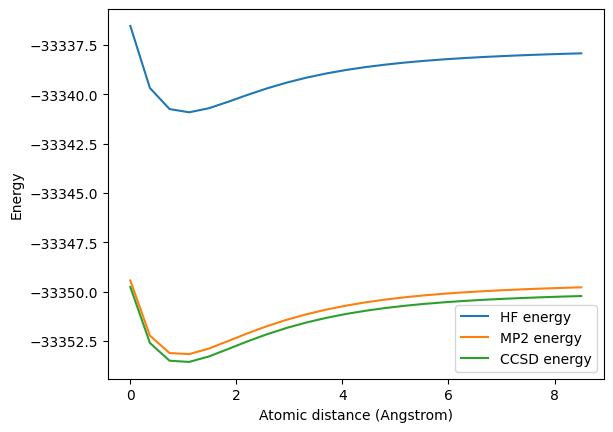

In [6]:
atomic_distance = df[df.keys()[1]]
hf_energy = df[df.keys()[2]]
mp2_energy = df[df.keys()[3]]
ccsd_energy = df[df.keys()[4]]

plt.plot(atomic_distance, hf_energy, label="HF energy")
plt.plot(atomic_distance, mp2_energy, label="MP2 energy")
plt.plot(atomic_distance, ccsd_energy, label="CCSD energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

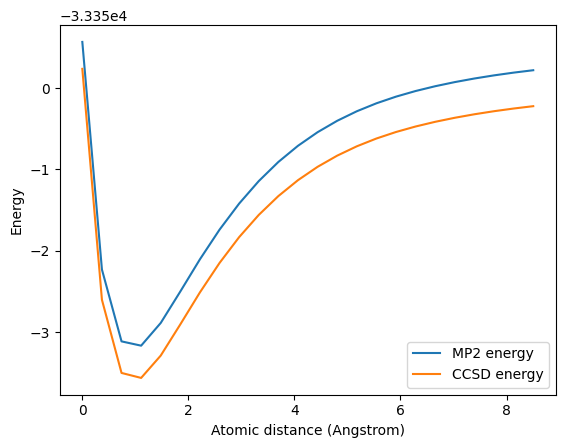

In [7]:
plt.plot(atomic_distance, mp2_energy, label="MP2 energy")
plt.plot(atomic_distance, ccsd_energy, label="CCSD energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

## Setup H2O @ Mn (II)

The results obtained from quantistry are with the `ccpvdz` basis, so we use it here. We consider all the electrons in system and keep the number of spatial orbitals to 4 so as to efficiently calculate the ground state energy.We use parity mapping as a mapper to map fermionic hamiltonian to qubit hamiltonian. We also apply two qubit reduction and symmetry reduction to reduce circuit's complexity. 

In [8]:
S = 5*0.5
charge = 2
basis = "ccpvdz"
num_electrons = None
num_spatial_orbitals = 3 # encodes eight spin orbitals
mapper_type = 'ParityMapper'
z2symmetry_reduction = 'auto'
ev = 27.2114
min_dist = 1.109187
actual_energy = -33353.561832

geometry = ""

with open(f"{ccsd_ref_dir}/step_003.xyz") as f:
    lines = f.readlines()[2:]
    for line in lines:
        values = line.split()
        geometry += f"{values[0]} {values[1]} {values[2]} {values[3]} ; "

geometry = geometry[:-3]

In [9]:
problem_reduced, converter, qubit_op, res_actual = construct_problem( geometry, 
                                                                      charge, 
                                                                      S, 
                                                                      basis, 
                                                                      mapper_type,
                                                                      num_spatial_orbitals,
                                                                      num_electrons, 
                                                                      z2symmetry_reduction=z2symmetry_reduction)

In [10]:
print(res_actual)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1284.294949281126
  - computed part:      -663.963762563311
  - ActiveSpaceTransformer extracted energy part: -620.331186717815
~ Nuclear repulsion energy (Hartree): 69.424951352255
> Total ground state energy (Hartree): -1214.869997928872
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [501.04487136  393.75357813  330.70493654]
 
  0: 
  * Electronic dipole moment (a.u.): [473.1110312  371.19386585  311.80745105]
    - computed part:      [78.79691733  68.09680748  56.69235609]
    - ActiveSpaceTransformer extracted energy part: [394.31411387  303.09705837  255.11509496]
  > Dipole moment (a.u.): [27.93384016  22.55971228  18.89748549]  Total: 40.57530039
                 (debye): [71.00073295  57.34106366  48.03261252]  Total: 103.13211685
 


In [11]:
exact_energy = res_actual.eigenvalues[0]
total_energy = res_actual.total_energies[0]
print(f'Expected ground state energy: {exact_energy:.12f} Ha')
print(f"Total energy: {total_energy} Ha")
print(f"Total energy in ev: {total_energy*ev} ev")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.963762563311 Ha
Total energy: -1214.8699979288717 Ha
Total energy in ev: -33058.3134616417 ev
Relative error: 0.008852079183


In [12]:
len(qubit_op), qubit_op.num_qubits

(58, 4)

## VQE H2O @ Mn(II)

With 4 spatial orbitals, we use SPSA optimizer for updating the parameters. Only single layer of the Hardware efficient ansatz is used. The number of hamiltonian terms are 58 and the number of qubits is 4. The computed Hartree-Fock state is $|1001>$. The total energy computed by Qiskit's Numpy minimum eigensolver is `-1214.8699` which is within  $10^{−2}$ Ha of the CCSD energy. The goal is to use VQE to reach the `computed part energy = -663.9637 Hartree`.

In [13]:
# configuration
execution_type = 'local'
optimizer_type = 'SPSA'
ansatz_type = 'TwoLocal'
reps = 1

# device config
noisy_sim = FakeNairobi()
num_device_qubits = noisy_sim.configuration().num_qubits
coupling_map = noisy_sim.configuration().coupling_map

In [14]:
ansatz = get_ansatz(ansatz_type, reps, problem_reduced, converter, qubit_op)
ansatz_opt, new_qubit_op = device_mapping(ansatz, noisy_sim, qubit_op, num_device_qubits)

In [15]:
ansatz.decompose().draw(fold = 200)

┌───────────┐┌──────────┐     ┌──────────┐                        
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[4]) ├────────────────────────
     └┬──────────┤└──────────┘┌─┴─┐└──────────┘┌──────────┐            
q_1: ─┤ Ry(θ[1]) ├────────────┤ X ├─────■──────┤ Ry(θ[5]) ├────────────
      ├──────────┤            └───┘   ┌─┴─┐    └──────────┘┌──────────┐
q_2: ─┤ Ry(θ[2]) ├────────────────────┤ X ├─────────■──────┤ Ry(θ[6]) ├
     ┌┴──────────┤┌──────────┐        └───┘       ┌─┴─┐    ├──────────┤
q_3: ┤ U3(π,0,π) ├┤ Ry(θ[3]) ├────────────────────┤ X ├────┤ Ry(θ[7]) ├
     └───────────┘└──────────┘                    └───┘    └──────────┘

In [16]:
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print('depth of the circuit:', ansatz_opt.depth())
print("total number of gates in the circuit:", sum(ansatz_opt.count_ops().values()))

number and type of gates in the cirucit: OrderedDict([('rz', 18), ('sx', 16), ('cx', 6), ('x', 2)])
number of parameters in the circuit: 8
depth of the circuit: 20
total number of gates in the circuit: 42


## Simulation

Picking an initial point is plays a significant role in convergence of the VQE algorithm. For this we created a helper function to find a multiplier for the initial point. We use this for crafting the initial point for the VQE. We run the algorithm for a maximum of 100 iterations.

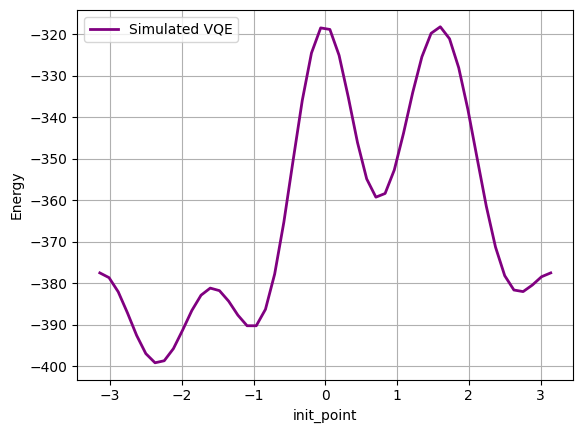

In [17]:
multiplier = init_point_finder(ansatz, optimizer_type, qubit_op)

In [18]:
multiplier 

-2.3722230241392315

In [21]:
optimizer = get_optimizer(optimizer_type, max_iter =100 , a = 0.01, c = 0.01)

estimator = Estimator(
        options = {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "seed": seed, 
            "seed_transpiler": seed,
            "optimization_level":0,
        }
    )

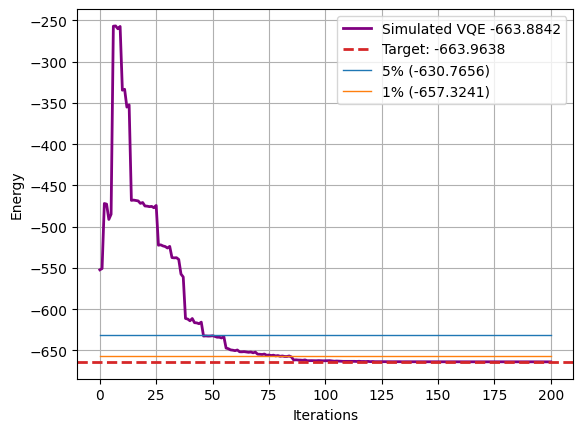

In [22]:
result, values = custom_vqe(estimator, 
                            ansatz_opt, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier)

In [23]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -663.8842284318948,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fde9215fbe0>,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -1.5781695338921222,
                              ParameterVectorElement(θ[7]): -1.4906206624350542,
                              ParameterVectorElement(θ[6]): -1.5735173563475062,
                              ParameterVectorElement(θ[1]): -1.5726946988838015,
                              ParameterVectorElement(θ[5]): -1.5709369188415732,
                              ParameterVectorElement(θ[2]): -1.568709236294861,
                              ParameterVectorElement(θ[4]): -1.6825708226438778,
                              ParameterVectorElement(θ[0]): -1.6862298356234233},
    'optimal_point': array([-1.68622984, -1.5726947 , -1.56870924, -1.57816953, -1.68257082,
       -1.57093692, -1.57351736, -1.49062066]),
    'opt

In [24]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.963762563311
Computed ground state energy: -663.884228431895
Relative error: 0.000119786856


In [25]:
interpreted_result = problem_reduced.interpret(result)
print(interpreted_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1284.21541514971
  - computed part:      -663.884228431895
  - ActiveSpaceTransformer extracted energy part: -620.331186717815
~ Nuclear repulsion energy (Hartree): 69.424951352255
> Total ground state energy (Hartree): -1214.790463797455
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [501.04487136  393.75357813  330.70493654]
 


In [26]:
total_energy = interpreted_result.total_energies[0]
print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -33353.561831999999 Ha

Total energy: -1214.790463797455 Ha
Total energy in ev: -33056.149226578076 ev

Relative error: 0.008916966857


## Results

The algorithm successufully converges to the computed part energy in ~20 seconds with a relative error within $10^{-3}$ Hartree.

The relative error of `VQE's ground state energy` with the `classical reference solution` is within $10^{-2}$ Hartree.

## Deparameterisation

We perfrom deparameterisation of the ansatz. Observe that most the parameters are approaching to standard values ($0, \pm \pi/2 \pm \pi$. We freeze these parameters and now we are left with only 3 parameters to optimize for. The optimization needed on 50 iterations (~10 seconds, a `50 percent decrease` in the runtime) with a relative errror within $10^{-3}$ Hartree.

The relative error of `VQE's ground state energy` with the `classical reference solution` is within $10^{-2}$ Hartree.

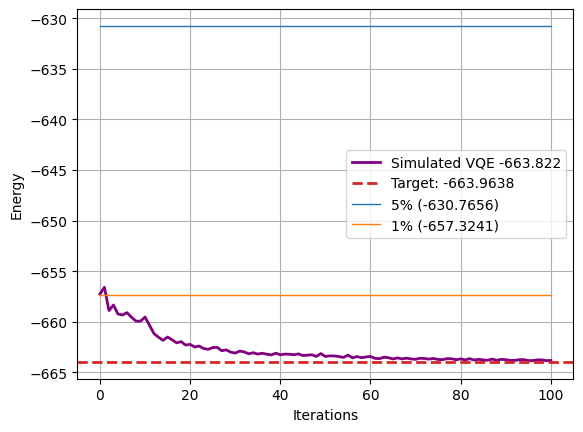

In [30]:
optimizer = get_optimizer(optimizer_type, max_iter = 50 , a = 0.01, c = 0.02)
tqc = deparameterise(result.optimal_circuit,
                     result.optimal_parameters,
                     [1,2,3,5,6], -np.pi/2)

l1_result, values = custom_vqe(estimator, 
                                tqc, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier)

In [31]:
print(l1_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 100,
    'eigenvalue': -663.8220415189651,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fde91cd5b80>,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -1.6815389064456454,
                              ParameterVectorElement(θ[4]): -2.205029331623705,
                              ParameterVectorElement(θ[0]): -2.2045925233512547},
    'optimal_point': array([-2.20459252, -2.20502933, -1.68153891]),
    'optimal_value': -663.8220415189651,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fde8dcdd190>,
    'optimizer_time': 10.425833940505981}


In [32]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, l1_result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.963762563311
Computed ground state energy: -663.884228431895
Relative error: 0.000213446957


In [33]:
interpreted_result = problem_reduced.interpret(l1_result)

total_energy = interpreted_result.total_energies[0]
print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -33353.561831999999 Ha

Total energy: -1214.728276884525 Ha
Total energy in ev: -33054.457033615581 ev

Relative error: 0.008967701857


## Noisy sim

We use Fake nairobi for noisy simulation provided by Qiskit. The noisy simulator consists of 7 qubits. We test the reduced parameter circuit with the noisy sim as backend. We try different error mitigation schemes which is controlled by the parameter `resilience level`.

Later we save the hamiltonian for using it with real hardware.

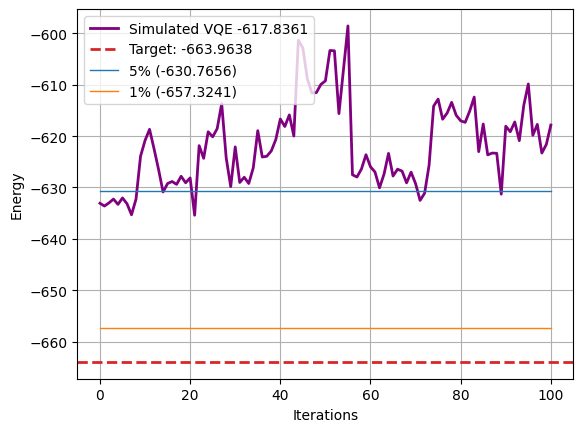

In [38]:
ansatz_opt = l1_result.optimal_circuit
initial_point = l1_result.optimal_point

noisy_sim_results = []
optimizer = get_optimizer(optimizer_type, max_iter = 50 , a = 0.01, c = 0.02)

for resilience_level in range(4):
    noisy_estimator = BackendEstimator(backend = noisy_sim, options = {
        'resilience_level': resilience_level,
        'shots': 1024,
    })

    result_noisy, values = custom_vqe(noisy_estimator, 
                                ansatz_opt, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None,
                                init_point = initial_point)

    noisy_sim_results.append(result_noisy)

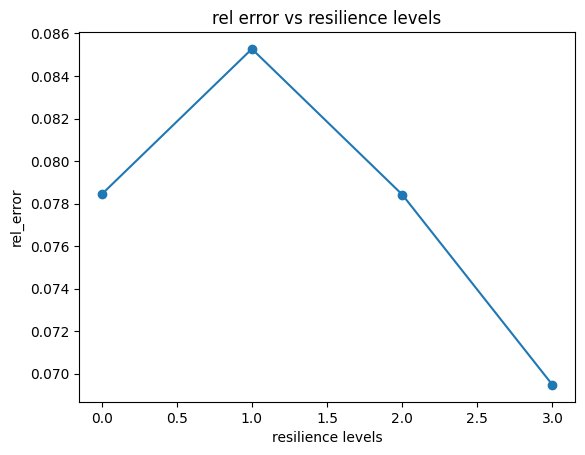

In [39]:
levels = list(range(len(noisy_sim_results)))
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in noisy_sim_results]
plt.plot(levels, rel_errors, marker='o')
plt.xlabel('resilience levels')
plt.ylabel('rel_error')
plt.title('rel error vs resilience levels');

In [40]:
interpreted_result = problem_reduced.interpret(noisy_sim_results[-1])

total_energy = interpreted_result.total_energies[0]
print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -33353.561831999999 Ha

Total energy: -1168.742329300425 Ha
Total energy in ev: -31803.115019525590 ev

Relative error: 0.046485194603


### Results with Noisy sim

The lowest relative error was achieved at `resilience level = 3` and the computed part energy is within 7 percent the actual computed part energy. There is a rise in the relative error with level=1 which is more than level=0 (no mitigation). The relative error decreases after level=2.

The relative error of `VQE's ground state energy` with the `classical reference solution` at `resilience level = 3` is within $10^{-1}$ Hartree (`4.6 percent`).

In [41]:
import pickle

H = {
    'coeffs': [],
    'ops': []
}

for op in qubit_op:
    pauli_string = op.primitive.paulis[0]
    pauli_string = pauli_string.__str__()

    pauli_coeff = op.primitive.coeffs[0]
    H['ops'].append(pauli_string)
    H['coeffs'].append(pauli_coeff)

with open('hamiltonian.pickle', 'wb') as handle:
    pickle.dump(H, handle, protocol=pickle.HIGHEST_PROTOCOL)

## VQE on AWS-DM1

In the next notebook, we take the VQE on the AWS DM1 Simulator for $H_2O @ MN (II)$ system. We use pennylane for this purpose and it has pennylane-braket-plugin.